In [ ]:
# !pip install pydicom

In [ ]:
# !pip install git+https://github.com/shijianjian/EfficientNet-PyTorch-3D

In [ ]:
# !pip install --upgrade https://github.com/VincentStimper/mclahe/archive/numpy.zip

In [1]:
import os
import sys 
import json
import glob
import random
import collections
import time

import numpy as np
import pandas as pd
import pydicom
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch.utils import data as torch_data
from sklearn import model_selection as sk_model_selection
from torch.nn import functional as torch_functional
import torch.nn.functional as F

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

from pathlib import Path
from efficientnet_pytorch_3d import EfficientNet3D

from tqdm.notebook import tqdm

import mclahe as mc

In [ ]:
class Config():
    epochs = 15
    batch_size = 8
    base_path = Path('/home/RSNA_MICCAI_Brain_Tumor/data')
    assert base_path.exists()
    models_path = Path('/home/RSNA_MICCAI_Brain_Tumor/models')
    assert models_path.exists()
    seed = 42
    num_workers = 7
    test_size = 0.1
    model_name = 'efficientnet3d-0'
    clahe = False
    
cfg = Config()

In [ ]:
if os.path.exists(cfg.base_path):
    data_directory = cfg.base_path
else:
    assert False, "data_directory does not exist"
    
# mri_types = ['FLAIR']
mri_types = ['FLAIR','T1w','T1wCE','T2w']
SIZE = 256
NUM_IMAGES = 64

### Functions to load images

In [4]:
# manual transformations
def brightness(X, gamma_factor = 0.35):
    """
    Changing the brighness of a image using power-law gamma transformation.
    Gain and gamma are chosen randomly for each image channel.
    
    Gain chosen between [0.8 - 1.2]
    Gamma chosen between [0.8 - 1.2]
    
    new_im = gain * im^gamma
    """
    
    X_new = np.zeros(X.shape)
    gain, gamma = (1.2 - gamma_factor) * np.random.random_sample(2,) + gamma_factor
    for c in range(X.shape[-1]):
        im = X[:,:,:,c]        
        im_new = np.sign(im)*gain*(np.abs(im)**gamma)
        X_new[:,:,:,c] = im_new 
    
    return X_new

def flip3D(X):
    """
    Flip the 3D image respect one of the 3 axis chosen randomly
    """
    choice = np.random.randint(4)
    if choice == 0: # flip on x
        X_flip = X[::-1, :, :, :]
    elif choice == 1: # flip on y
        X_flip = X[:, ::-1, :, :]
    elif choice == 2: # flip on z
        X_flip = X[:, :, ::-1, :]
    else:
        X_flip = X
        
    return np.flip(X_flip,axis=0).copy()

In [57]:
def load_dicom_image(path, img_size=SIZE, clahe=False):
    dicom = pydicom.read_file(path)
    data = dicom.pixel_array
    max_data = np.max(data)
    min_data = np.min(data)
    if min_data == max_data:
        data = np.zeros((img_size,img_size))
        return data
    data = data - min_data
    if max_data != 0:
        data = data / (max_data - min_data) 
    
    #data = (data * 255).astype(np.uint8)
    data = cv2.resize(data, (img_size, img_size))
    return data

def convert_vertical(x, size=224):
    x = np.moveaxis(x, -1, 0)
    X_new = np.zeros([size, size, size])
    for c in range(x.shape[-1]):
        im = x[:,:,c]
        X_new[:,:,c] = cv2.resize(im, [size, size])
    return X_new

def load_dicom_images_3d(scan_id, num_imgs=NUM_IMAGES, img_size=SIZE, mri_type="FLAIR", split="train", clahe=False, convert_vertical_flag=True):

    files = sorted(glob.glob(f"{data_directory}/{split}/{scan_id}/{mri_type}/*.dcm"))
    
    middle = len(files)//2
    num_imgs2 = num_imgs//2
    p1 = max(0, middle - num_imgs2)
    p2 = min(len(files), middle + num_imgs2)
    img3d = np.stack([load_dicom_image(f, clahe=clahe) for f in files[p1:p2]]).T 
    if img3d.shape[-1] < num_imgs:
        n_zero = np.zeros((img_size, img_size, num_imgs - img3d.shape[-1]))
        img3d = np.concatenate((img3d,  n_zero), axis = -1)
    img3d = img3d[:,:,:]
    # Transforms
#     img3d = flip3D(brightness(img3d))
#     if convert_vertical_flag:
#         img3d_vert = convert_vertical(img3d, size=img3d.shape[0])
#         img3d = np.concatenate([img3d, img3d_vert], axis=-1)
    return np.expand_dims(img3d[:,:,:], 0)



In [58]:
sample_image_0 = load_dicom_images_3d("00000", convert_vertical_flag=True)
sample_image_0.shape

(1, 256, 256, 64)

In [59]:
# sample_image_1 = load_dicom_images_3d("00000", convert_vertical_flag=True)
# sample_image_1.shape

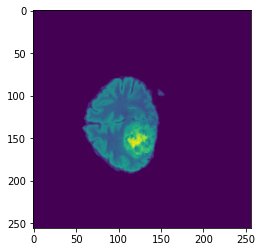

In [60]:
plt.imshow(sample_image_0[:,:,:,12].squeeze())

(-0.5, 255.5, 255.5, -0.5)

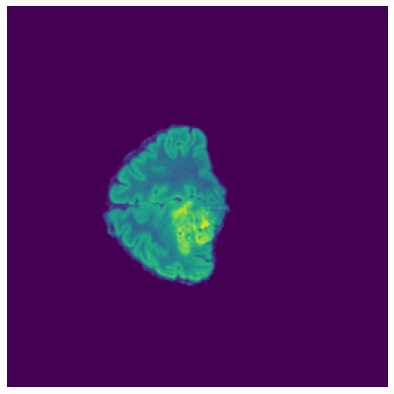

In [84]:
sample_image = load_dicom_images_3d("00000")
sample_slice = sample_image.squeeze()[:,:,33]
plt.figure(figsize=(10, 7))
plt.imshow(sample_slice)
plt.axis('off')

(-0.5, 255.5, 255.5, -0.5)

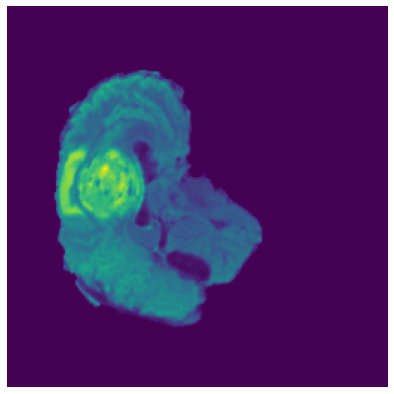

In [87]:
sample_image = load_dicom_images_3d("00003")
sample_slice = sample_image.squeeze()[:,:,31]
plt.figure(figsize=(10, 7))
plt.imshow(sample_slice)
plt.axis('off')

(-0.5, 255.5, 255.5, -0.5)

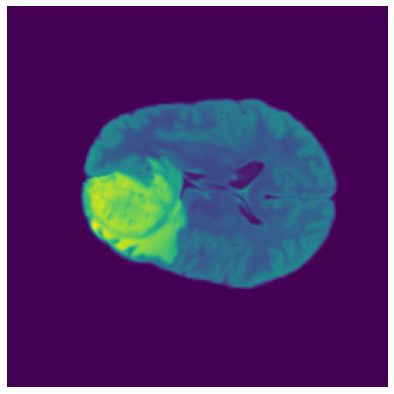

In [88]:
sample_image = load_dicom_images_3d("00006")
sample_slice = sample_image.squeeze()[:,:,40]
plt.figure(figsize=(10, 7))
plt.imshow(sample_slice)
plt.axis('off')

In [89]:
def set_seed(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True

set_seed(cfg.seed)

### train / test splits

In [90]:
test_df = pd.read_csv(f"{data_directory}/sample_submission.csv", index_col="BraTS21ID")

In [91]:
test_df

,MGMT_value
BraTS21ID,
1,0.5
13,0.5
15,0.5
27,0.5
37,0.5
...,...
826,0.5
829,0.5
833,0.5


In [92]:
train_df = pd.read_csv(f"{data_directory}/train_labels.csv")
train_df

,BraTS21ID,MGMT_value
0,0,1
1,2,1
2,3,0
3,5,1
4,6,1
...,...,...
580,1005,1
581,1007,1
582,1008,1
583,1009,0


In [93]:
train_df = train_df.drop(train_df[train_df['BraTS21ID'].isin([109, 123, 709])].index)

In [94]:

display(train_df)

df_train, df_valid = sk_model_selection.train_test_split(
    train_df, 
    test_size=cfg.test_size, 
    random_state=42, 
    stratify=train_df["MGMT_value"],
)


,BraTS21ID,MGMT_value
0,0,1
1,2,1
2,3,0
3,5,1
4,6,1
...,...,...
580,1005,1
581,1007,1
582,1008,1
583,1009,0


In [95]:
df_valid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59 entries, 386 to 568
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   BraTS21ID   59 non-null     int64
 1   MGMT_value  59 non-null     int64
dtypes: int64(2)
memory usage: 1.4 KB


In [96]:
df_valid = df_valid.append(pd.DataFrame([{'BraTS21ID': 1, 'MGMT_value': 1}, {'BraTS21ID': 13, 'MGMT_value': 1}]))

In [97]:
df_valid

,BraTS21ID,MGMT_value
386,565,0
285,413,1
229,332,1
239,347,0
286,414,0
...,...,...
410,594,1
561,819,1
568,836,0
0,1,1


In [98]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 523 entries, 549 to 347
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   BraTS21ID   523 non-null    int64
 1   MGMT_value  523 non-null    int64
dtypes: int64(2)
memory usage: 12.3 KB


### Model and training classes

In [99]:
class Dataset(torch_data.Dataset):
    def __init__(self, paths, targets=None, mri_type=None, label_smoothing=0.01, split="train"):
        self.paths = paths
        self.targets = targets
        self.mri_type = mri_type
        self.label_smoothing = label_smoothing
        self.split = split
          
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, index):
        scan_id = self.paths[index]
        if self.targets is None:
            data = load_dicom_images_3d(str(scan_id).zfill(5), mri_type=self.mri_type[index], split=self.split, clahe=cfg.clahe)
        else:
            data = load_dicom_images_3d(str(scan_id).zfill(5), mri_type=self.mri_type[index], split="train", clahe=cfg.clahe)

        if self.targets is None:
            return {"X": torch.tensor(data).float(), "id": scan_id}
        else:
            y = torch.tensor(abs(self.targets[index]-self.label_smoothing), dtype=torch.float)
            return {"X": torch.tensor(data).float(), "y": y}


In [23]:
class ModelHead(nn.Module):
    
    def __init__(self, in_features, hidden_dim):
        super().__init__()
        self._fc = nn.Linear(in_features=in_features, out_features=hidden_dim, bias=True)
        self._fc_2 = nn.Linear(in_features=hidden_dim, out_features=1, bias=True)
        
    def forward(self, x):
        x = self._fc(x)
        x = self._fc_2(x)
        return x

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = EfficientNet3D.from_name("efficientnet-b0", override_params={'num_classes': 2}, in_channels=1)
        n_features = self.net._fc.in_features
        self.net._fc = ModelHead(n_features, 600)
        
    
    def forward(self, x):
        out = self.net(x)
        return out
    

In [142]:
class AttentionHead(nn.Module):
    
    def __init__(self, in_features, hidden_dim, num_targets):
        super().__init__()
        self.in_features = in_features
        
        self.hidden_layer = nn.Linear(in_features, hidden_dim)
        self.final_layer = nn.Linear(hidden_dim, num_targets)
        self.out_features = hidden_dim
        
    def forward(self, features):
        att = torch.tanh(self.hidden_layer(features))
        score = self.final_layer(att)
        attention_weights = torch.softmax(score, dim=1)
        context_vector = torch.sum(attention_weights * features, dim=1) 
        return context_vector.unsqueeze(1)

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = EfficientNet3D.from_name("efficientnet-b0", override_params={'num_classes': 2}, in_channels=1)
        n_features = self.net._fc.in_features
        self.net._fc = AttentionHead(n_features, 600, 1)
        
    
    def forward(self, x):
        out = self.net(x)
        return torch.sigmoid(out)
    

In [143]:
attention_head = AttentionHead(1028, 600, 1)

In [144]:
attention_head(torch.randn([8, 1028])).shape

torch.Size([8, 1])

In [145]:
extra_check_epochs = [9, 10, 11]

In [146]:
sample_input = torch.randn([8, 1, 256, 256, 320]).cuda()

In [147]:
sample_model = Model().cuda()

In [148]:
sample_model.net.get_image_size("efficientnet-b0")

224

In [149]:
sample_model(sample_input).shape

torch.Size([8, 1])

In [150]:
min(extra_check_epochs)

9

In [151]:
class Trainer:
    def __init__(
        self, 
        model, 
        device, 
        optimizer, 
        criterion
    ):
        self.model = model
        self.device = device
        self.optimizer = optimizer
        self.criterion = criterion

        self.best_valid_score = np.inf
        self.n_patience = 0
        self.lastmodel = None
        
    def fit(self, epochs, train_loader, valid_loader, save_path, patience):  
        tbar = tqdm(range(1, epochs + 1), total=epochs)
#         self.lr_sched = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(self.optimizer, T_0=int(len(train_loader) / 2), T_mult=1, eta_min=0.0001, last_epoch=-1)
        self.lr_sched = torch.optim.lr_scheduler.OneCycleLR(self.optimizer, max_lr=1e-3, steps_per_epoch=len(train_loader), epochs=epochs)
        self.lrs = []
        
        for n_epoch in tbar:
            
            self.info_message("EPOCH: {}", n_epoch)
            tbar.set_description(f'EPOCH: {n_epoch}')
            
            
            train_loss, train_time = self.train_epoch(train_loader, valid_loader, n_epoch, save_path)
            valid_loss, valid_auc, valid_time = self.valid_epoch(valid_loader)
            
            self.info_message(
                "[Epoch Train: {}] loss: {:.4f}, time: {:.2f} s            ",
                n_epoch, train_loss, train_time
            )
            
            self.print_valid_message(valid_loss, valid_auc, valid_time, n_epoch)
            
            self.check_and_save(valid_loss, valid_auc, valid_time, n_epoch, save_path)
            
            if self.n_patience >= patience:
                self.info_message("\nValid auc didn't improve last {} epochs.", patience)
                break
        plt.plot(self.lrs)
        
    def check_and_save(self, valid_loss, valid_auc, valid_time, n_epoch, save_path):
        # if True:
        # if self.best_valid_score < valid_auc: 
        if self.best_valid_score > valid_loss and n_epoch >= min(extra_check_epochs) and valid_auc > 0.5: 
            self.save_model(n_epoch, save_path, valid_loss, valid_auc)
            self.info_message(
                 "auc improved from {:.4f} to {:.4f}. Saved model to '{}'", 
                self.best_valid_score, valid_loss, self.lastmodel
            )
            self.best_valid_score = valid_loss
            self.n_patience = 0
        else:
            self.n_patience += 1
            
    def print_valid_message(self, valid_loss, valid_auc, valid_time, n_epoch):
        self.info_message(
            "[Epoch Valid: {}] loss: {:.4f}, auc: {:.4f}, time: {:.2f} s",
            n_epoch, valid_loss, valid_auc, valid_time
        )
            
    def train_epoch(self, train_loader, valid_loader, n_epoch, save_path):
        self.model.train()
        t = time.time()
        sum_loss = 0

        tbar = tqdm(enumerate(train_loader, 1), total=len(train_loader))
        
        for step, batch in tbar:
            X = batch["X"].to(self.device)
            targets = batch["y"].to(self.device)
            self.optimizer.zero_grad()
            outputs = self.model(X).squeeze(1)
            
            loss = self.criterion(outputs, targets)
            loss.backward()

            sum_loss += loss.detach().item()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
            self.optimizer.step()
            self.lr_sched.step()
            current_lr = self.optimizer.param_groups[0]["lr"]
            self.lrs.append(
                current_lr
            )
            
            message = 'Train Step {}/{}, train_loss: {:.4f}'
            self.info_message(message, step, len(train_loader), sum_loss/step, end="\r")
            
            if n_epoch in extra_check_epochs:
                if step % 3 == 0:
                    valid_loss, valid_auc, valid_time = self.valid_epoch(valid_loader)
                    self.check_and_save(valid_loss, valid_auc, valid_time, n_epoch, save_path)
                    self.print_valid_message(valid_loss, valid_auc, valid_time, n_epoch)
            
        
        return sum_loss/len(train_loader), int(time.time() - t)
    
    def valid_epoch(self, valid_loader):
        self.model.eval()
        t = time.time()
        sum_loss = 0
        y_all = []
        outputs_all = []

        tbar = tqdm(enumerate(valid_loader, 1), total=len(valid_loader))
        for step, batch in tbar:
            with torch.no_grad():
                X = batch["X"].to(self.device)
                targets = batch["y"].to(self.device)

                outputs = self.model(X).squeeze(1)
                loss = self.criterion(outputs, targets)
                print('outputs', outputs.mean().item(), outputs.std().item())
                print('targets', targets.mean().item(), targets.std().item())
                
                sum_loss += loss.detach().item()
                y_all.extend(batch["y"].tolist())
                outputs_all.extend(outputs.tolist())

            message = 'Valid Step {}/{}, valid_loss: {:.4f}'
            self.info_message(message, step, len(valid_loader), sum_loss/step, end="\r")
            
        y_all = [1 if x > 0.5 else 0 for x in y_all]
        auc = roc_auc_score(y_all, outputs_all)
        
        return sum_loss/len(valid_loader), auc, int(time.time() - t)
    
    def save_model(self, n_epoch, save_path, loss, auc):
        self.lastmodel = str(cfg.models_path/f"{save_path}-e{n_epoch}-loss{loss:.3f}-auc{auc:.3f}.pth")
        torch.save(
            {
                "model_state_dict": self.model.state_dict(),
                "optimizer_state_dict": self.optimizer.state_dict(),
                "best_valid_score": self.best_valid_score,
                "n_epoch": n_epoch,
            },
            self.lastmodel,
        )
    
    @staticmethod
    def info_message(message, *args, end="\n"):
        print(message.format(*args), end=end)

In [152]:
def dice_loss(input, target, eps=1e-6):
    input = input.clamp_min(0)
    intersection = torch.sum(input * target)
    cardinality = torch.sum(input + target)
    return 1.0 - (2.0 * intersection) / (cardinality).clamp_min(eps)

In [153]:
def loss_func(input, target):
#     return F.binary_cross_entropy_with_logits(input, target) * 0.5 + F.mse_loss(input, target) * 0.5
#     return F.binary_cross_entropy_with_logits(input, target) * 0.2 + dice_loss(input, target) * 0.8
    return F.binary_cross_entropy_with_logits(input, target)

In [154]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_mri_type(df_train, df_valid, mri_type):
    if mri_type=="all":
        train_list = []
        valid_list = []
        for mri_type in mri_types:
            df_train.loc[:,"MRI_Type"] = mri_type
            train_list.append(df_train.copy())
            df_valid.loc[:,"MRI_Type"] = mri_type
            valid_list.append(df_valid.copy())

        df_train = pd.concat(train_list)
        df_valid = pd.concat(valid_list)
    else:
        df_train.loc[:,"MRI_Type"] = mri_type
        df_valid.loc[:,"MRI_Type"] = mri_type

    print(df_train.shape, df_valid.shape)
    display(df_train.head())
    
    train_data_retriever = Dataset(
        df_train["BraTS21ID"].values, 
        df_train["MGMT_value"].values, 
        df_train["MRI_Type"].values
    )

    valid_data_retriever = Dataset(
        df_valid["BraTS21ID"].values, 
        df_valid["MGMT_value"].values,
        df_valid["MRI_Type"].values
    )

    train_loader = torch_data.DataLoader(
        train_data_retriever,
        batch_size=cfg.batch_size,
        shuffle=True,
        num_workers=cfg.num_workers,
    )

    valid_loader = torch_data.DataLoader(
        valid_data_retriever, 
        batch_size=cfg.batch_size,
        shuffle=False,
        num_workers=cfg.num_workers,
    )

    model = Model()
    model.to(device)

    #checkpoint = torch.load("best-model-all-auc0.555.pth")
    #model.load_state_dict(checkpoint["model_state_dict"])

    #print(model)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    #optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    criterion = loss_func

    trainer = Trainer(
        model, 
        device, 
        optimizer, 
        criterion
    )

    history = trainer.fit(
        cfg.epochs, 
        train_loader, 
        valid_loader, 
        f"{mri_type}", 
        cfg.epochs + 100,
    )
    
    return trainer.lastmodel

In [155]:
!rm -rf {str(cfg.models_path)}/*.pth

In [156]:
modelfiles = None

if not modelfiles:
    modelfiles = [train_mri_type(df_train, df_valid, m) for m in mri_types]
    print(modelfiles)

(523, 3) (61, 3)


/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,BraTS21ID,MGMT_value,MRI_Type
549,803,0,FLAIR
353,520,1,FLAIR
272,399,0,FLAIR
137,206,0,FLAIR
292,423,0,FLAIR


EPOCH: 1


Train Step 66/66, train_loss: 0.7898


outputs 0.46531790494918823 1.951019967805223e-08
targets 0.5 0.5238320827484131
outputs 0.46531790494918823 1.951019967805223e-08
targets 0.6225000023841858 0.5071982145309448
outputs 0.46531790494918823 1.951019967805223e-08
targets 0.5 0.5238320827484131
outputs 0.46531790494918823 1.951019967805223e-08
targets 0.6225000023841858 0.5071982145309448
outputs 0.46531790494918823 2.759158945764284e-08
targets 0.3774999976158142 0.5071982145309448
outputs 0.46531790494918823 2.759158945764284e-08
targets 0.3774999976158142 0.5071982145309448
outputs 0.46531790494918823 1.951019967805223e-08
targets 0.6225000023841858 0.5071982145309448
outputs 0.4653179347515106 0.07118
targets 0.7940000295639038 0.43826931715011597
Valid Step 8/8, valid_loss: 0.6957
[Epoch Train: 1] loss: 0.7898, time: 57.00 s            
[Epoch Valid: 1] loss: 0.6957, auc: 0.4383, time: 4.00 s
EPOCH: 2


Train Step 66/66, train_loss: 0.7867


outputs 0.5751162767410278 2.759158945764284e-08
targets 0.5 0.5238320827484131
outputs 0.5751162767410278 3.1860022176033453e-08
targets 0.6225000023841858 0.5071982145309448
outputs 0.5751162767410278 3.1860022176033453e-08
targets 0.5 0.5238320827484131
outputs 0.5751162767410278 2.759158945764284e-08
targets 0.6225000023841858 0.5071982145309448
outputs 0.5751162767410278 2.759158945764284e-08
targets 0.3774999976158142 0.5071982145309448
outputs 0.5751162767410278 3.1860022176033453e-08
targets 0.3774999976158142 0.5071982145309448
outputs 0.5751162767410278 3.562058736861218e-08
targets 0.6225000023841858 0.5071982145309448
outputs 0.5751162767410278 4.8666990437595814e-08
targets 0.7940000295639038 0.43826931715011597
Valid Step 8/8, valid_loss: 0.7040
[Epoch Train: 2] loss: 0.7867, time: 57.00 s            
[Epoch Valid: 2] loss: 0.7040, auc: 0.5043, time: 4.00 s
EPOCH: 3


Train Step 66/66, train_loss: 0.7867


outputs 0.865662157535553 5.743647335521018e-08
targets 0.5 0.5238320827484131
outputs 0.8656620979309082 6.568112098648271e-08
targets 0.6225000023841858 0.5071982145309448
outputs 0.865662157535553 9.689847502158955e-08
targets 0.5 0.5238320827484131
outputs 0.8656622171401978 7.124117473722436e-08
targets 0.6225000023841858 0.5071982145309448
outputs 0.8656620979309082 7.639765442490898e-08
targets 0.3774999976158142 0.5071982145309448
outputs 0.865662157535553 7.965005721644047e-08
targets 0.3774999976158142 0.5071982145309448
outputs 0.865662157535553 0.0.7840
targets 0.6225000023841858 0.5071982145309448
outputs 0.8656622171401978 7.598131190889035e-08
targets 0.7940000295639038 0.43826931715011597
Valid Step 8/8, valid_loss: 0.7390
[Epoch Train: 3] loss: 0.7867, time: 57.00 s            
[Epoch Valid: 3] loss: 0.7390, auc: 0.4724, time: 4.00 s
EPOCH: 4


Train Step 66/66, train_loss: 0.7867


outputs 0.9926234483718872 1.1706119806831339e-07
targets 0.5 0.5238320827484131
outputs 0.9926234483718872 9.288712732313797e-08
targets 0.6225000023841858 0.5071982145309448
outputs 0.9926234483718872 1.1264219068607417e-07
targets 0.5 0.5238320827484131
outputs 0.9926234483718872 1.0566773767095583e-07
targets 0.6225000023841858 0.5071982145309448
outputs 0.9926234483718872 9.288712732313797e-08
targets 0.3774999976158142 0.5071982145309448
outputs 0.9926233887672424 1.0566773767095583e-07
targets 0.3774999976158142 0.5071982145309448
outputs 0.9926234483718872 7.471837903949563e-08
targets 0.6225000023841858 0.5071982145309448
outputs 0.9926234483718872 2.1791727533582161e-07
targets 0.7940000295639038 0.43826931715011597
Valid Step 8/8, valid_loss: 0.7599
[Epoch Train: 4] loss: 0.7867, time: 57.00 s            
[Epoch Valid: 4] loss: 0.7599, auc: 0.4421, time: 4.00 s
EPOCH: 5


Train Step 66/66, train_loss: 0.7898


outputs 0.9999198913574219 0.0
targets 0.5 0.5238320827484131
outputs 0.9999198913574219 3.902039935610446e-08
targets 0.6225000023841858 0.5071982145309448
outputs 0.9999198913574219 6.758531156947356e-08
targets 0.5 0.5238320827484131
outputs 0.9999198913574219 3.902039935610446e-08
targets 0.6225000023841858 0.5071982145309448
outputs 0.9999198913574219 5.518317891528568e-08
targets 0.3774999976158142 0.5071982145309448
outputs 0.9999198913574219 3.902039935610446e-08
targets 0.3774999976158142 0.5071982145309448
outputs 0.9999198913574219 5.518317891528568e-08
targets 0.6225000023841858 0.5071982145309448
outputs 0.9999198913574219 5.860281504510567e-08
targets 0.7940000295639038 0.43826931715011597
Valid Step 8/8, valid_loss: 0.7612
[Epoch Train: 5] loss: 0.7898, time: 57.00 s            
[Epoch Valid: 5] loss: 0.7612, auc: 0.4984, time: 4.00 s
EPOCH: 6


Train Step 66/66, train_loss: 0.7867


outputs 0.9999996423721313 0.0
targets 0.5 0.5238320827484131
outputs 0.9999996423721313 0.08133
targets 0.6225000023841858 0.5071982145309448
outputs 0.9999996423721313 0.07520
targets 0.5 0.5238320827484131
outputs 0.9999996423721313 0.07724
targets 0.6225000023841858 0.5071982145309448
outputs 0.9999996423721313 0.07520
targets 0.3774999976158142 0.5071982145309448
outputs 0.9999996423721313 0.07888
targets 0.3774999976158142 0.5071982145309448
outputs 0.9999996423721313 0.08133
targets 0.6225000023841858 0.5071982145309448
outputs 0.9999996423721313 0.07958
targets 0.7940000295639038 0.43826931715011597
Valid Step 8/8, valid_loss: 0.7612
[Epoch Train: 6] loss: 0.7867, time: 57.00 s            
[Epoch Valid: 6] loss: 0.7612, auc: 0.5000, time: 4.00 s
EPOCH: 7


Train Step 66/66, train_loss: 0.7867


outputs 1.0 0.0
targets 0.5 0.5238320827484131
outputs 1.0 0.0 valid_loss: 0.8133
targets 0.6225000023841858 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.7520
targets 0.5 0.5238320827484131
outputs 1.0 0.0 valid_loss: 0.7724
targets 0.6225000023841858 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.7520
targets 0.3774999976158142 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.7888
targets 0.3774999976158142 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.8133
targets 0.6225000023841858 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.7958
targets 0.7940000295639038 0.43826931715011597
Valid Step 8/8, valid_loss: 0.7612
[Epoch Train: 7] loss: 0.7867, time: 57.00 s            
[Epoch Valid: 7] loss: 0.7612, auc: 0.5000, time: 4.00 s
EPOCH: 8


Train Step 66/66, train_loss: 0.7898


outputs 1.0 0.0
targets 0.5 0.5238320827484131
outputs 1.0 0.0 valid_loss: 0.8133
targets 0.6225000023841858 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.7520
targets 0.5 0.5238320827484131
outputs 1.0 0.0 valid_loss: 0.7724
targets 0.6225000023841858 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.7520
targets 0.3774999976158142 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.7888
targets 0.3774999976158142 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.8133
targets 0.6225000023841858 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.7958
targets 0.7940000295639038 0.43826931715011597
Valid Step 8/8, valid_loss: 0.7612
[Epoch Train: 8] loss: 0.7898, time: 57.00 s            
[Epoch Valid: 8] loss: 0.7612, auc: 0.5000, time: 4.00 s
EPOCH: 9


outputs 1.0 0.0
targets 0.5 0.5238320827484131
outputs 1.0 0.0 valid_loss: 0.8133
targets 0.6225000023841858 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.7520
targets 0.5 0.5238320827484131
outputs 1.0 0.0 valid_loss: 0.7724
targets 0.6225000023841858 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.7520
targets 0.3774999976158142 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.7888
targets 0.3774999976158142 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.8133
targets 0.6225000023841858 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.7958
targets 0.7940000295639038 0.43826931715011597
Valid Step 8/8, valid_loss: 0.7612
[Epoch Valid: 9] loss: 0.7612, auc: 0.5000, time: 4.00 s


outputs 1.0 0.0
targets 0.5 0.5238320827484131
outputs 1.0 0.0 valid_loss: 0.8133
targets 0.6225000023841858 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.7520
targets 0.5 0.5238320827484131
outputs 1.0 0.0 valid_loss: 0.7724
targets 0.6225000023841858 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.7520
targets 0.3774999976158142 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.7888
targets 0.3774999976158142 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.8133
targets 0.6225000023841858 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.7958
targets 0.7940000295639038 0.43826931715011597
Valid Step 8/8, valid_loss: 0.7612
[Epoch Valid: 9] loss: 0.7612, auc: 0.5000, time: 4.00 s


outputs 1.0 0.0
targets 0.5 0.5238320827484131
outputs 1.0 0.0 valid_loss: 0.8133
targets 0.6225000023841858 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.7520
targets 0.5 0.5238320827484131
outputs 1.0 0.0 valid_loss: 0.7724
targets 0.6225000023841858 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.7520
targets 0.3774999976158142 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.7888
targets 0.3774999976158142 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.8133
targets 0.6225000023841858 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.7958
targets 0.7940000295639038 0.43826931715011597
Valid Step 8/8, valid_loss: 0.7612
[Epoch Valid: 9] loss: 0.7612, auc: 0.5000, time: 4.00 s


outputs 1.0 0.0
targets 0.5 0.5238320827484131
outputs 1.0 0.0 valid_loss: 0.8133
targets 0.6225000023841858 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.7520
targets 0.5 0.5238320827484131
outputs 1.0 0.0 valid_loss: 0.7724
targets 0.6225000023841858 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.7520
targets 0.3774999976158142 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.7888
targets 0.3774999976158142 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.8133
targets 0.6225000023841858 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.7958
targets 0.7940000295639038 0.43826931715011597
Valid Step 8/8, valid_loss: 0.7612
[Epoch Valid: 9] loss: 0.7612, auc: 0.5000, time: 4.00 s


outputs 1.0 0.0
targets 0.5 0.5238320827484131
outputs 1.0 0.0 valid_loss: 0.8133
targets 0.6225000023841858 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.7520
targets 0.5 0.5238320827484131
outputs 1.0 0.0 valid_loss: 0.7724
targets 0.6225000023841858 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.7520
targets 0.3774999976158142 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.7888
targets 0.3774999976158142 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.8133
targets 0.6225000023841858 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.7958
targets 0.7940000295639038 0.43826931715011597
Valid Step 8/8, valid_loss: 0.7612
[Epoch Valid: 9] loss: 0.7612, auc: 0.5000, time: 4.00 s


outputs 1.0 0.0
targets 0.5 0.5238320827484131
outputs 1.0 0.0 valid_loss: 0.8133
targets 0.6225000023841858 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.7520
targets 0.5 0.5238320827484131
outputs 1.0 0.0 valid_loss: 0.7724
targets 0.6225000023841858 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.7520
targets 0.3774999976158142 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.7888
targets 0.3774999976158142 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.8133
targets 0.6225000023841858 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.7958
targets 0.7940000295639038 0.43826931715011597
Valid Step 8/8, valid_loss: 0.7612
[Epoch Valid: 9] loss: 0.7612, auc: 0.5000, time: 4.00 s


outputs 1.0 0.0
targets 0.5 0.5238320827484131
outputs 1.0 0.0 valid_loss: 0.8133
targets 0.6225000023841858 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.7520
targets 0.5 0.5238320827484131
outputs 1.0 0.0 valid_loss: 0.7724
targets 0.6225000023841858 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.7520
targets 0.3774999976158142 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.7888
targets 0.3774999976158142 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.8133
targets 0.6225000023841858 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.7958
targets 0.7940000295639038 0.43826931715011597
Valid Step 8/8, valid_loss: 0.7612
[Epoch Valid: 9] loss: 0.7612, auc: 0.5000, time: 4.00 s


outputs 1.0 0.0
targets 0.5 0.5238320827484131
outputs 1.0 0.0 valid_loss: 0.8133
targets 0.6225000023841858 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.7520
targets 0.5 0.5238320827484131
outputs 1.0 0.0 valid_loss: 0.7724
targets 0.6225000023841858 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.7520
targets 0.3774999976158142 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.7888
targets 0.3774999976158142 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.8133
targets 0.6225000023841858 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.7958
targets 0.7940000295639038 0.43826931715011597
Valid Step 8/8, valid_loss: 0.7612
[Epoch Valid: 9] loss: 0.7612, auc: 0.5000, time: 4.00 s


outputs 1.0 0.0
targets 0.5 0.5238320827484131
outputs 1.0 0.0 valid_loss: 0.8133
targets 0.6225000023841858 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.7520
targets 0.5 0.5238320827484131
outputs 1.0 0.0 valid_loss: 0.7724
targets 0.6225000023841858 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.7520
targets 0.3774999976158142 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.7888
targets 0.3774999976158142 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.8133
targets 0.6225000023841858 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.7958
targets 0.7940000295639038 0.43826931715011597
Valid Step 8/8, valid_loss: 0.7612
[Epoch Valid: 9] loss: 0.7612, auc: 0.5000, time: 4.00 s


outputs 1.0 0.0
targets 0.5 0.5238320827484131
outputs 1.0 0.0 valid_loss: 0.8133
targets 0.6225000023841858 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.7520
targets 0.5 0.5238320827484131
outputs 1.0 0.0 valid_loss: 0.7724
targets 0.6225000023841858 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.7520
targets 0.3774999976158142 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.7888
targets 0.3774999976158142 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.8133
targets 0.6225000023841858 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.7958
targets 0.7940000295639038 0.43826931715011597
Valid Step 8/8, valid_loss: 0.7612
[Epoch Valid: 9] loss: 0.7612, auc: 0.5000, time: 4.00 s


outputs 1.0 0.0
targets 0.5 0.5238320827484131
outputs 1.0 0.0 valid_loss: 0.8133
targets 0.6225000023841858 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.7520
targets 0.5 0.5238320827484131
outputs 1.0 0.0 valid_loss: 0.7724
targets 0.6225000023841858 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.7520
targets 0.3774999976158142 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.7888
targets 0.3774999976158142 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.8133
targets 0.6225000023841858 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.7958
targets 0.7940000295639038 0.43826931715011597
Valid Step 8/8, valid_loss: 0.7612
[Epoch Valid: 9] loss: 0.7612, auc: 0.5000, time: 4.00 s


outputs 1.0 0.0
targets 0.5 0.5238320827484131
outputs 1.0 0.0 valid_loss: 0.8133
targets 0.6225000023841858 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.7520
targets 0.5 0.5238320827484131
outputs 1.0 0.0 valid_loss: 0.7724
targets 0.6225000023841858 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.7520
targets 0.3774999976158142 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.7888
targets 0.3774999976158142 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.8133
targets 0.6225000023841858 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.7958
targets 0.7940000295639038 0.43826931715011597
Valid Step 8/8, valid_loss: 0.7612
[Epoch Valid: 9] loss: 0.7612, auc: 0.5000, time: 4.00 s


outputs 1.0 0.0
targets 0.5 0.5238320827484131
outputs 1.0 0.0 valid_loss: 0.8133
targets 0.6225000023841858 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.7520
targets 0.5 0.5238320827484131
outputs 1.0 0.0 valid_loss: 0.7724
targets 0.6225000023841858 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.7520
targets 0.3774999976158142 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.7888
targets 0.3774999976158142 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.8133
targets 0.6225000023841858 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.7958
targets 0.7940000295639038 0.43826931715011597
Valid Step 8/8, valid_loss: 0.7612
[Epoch Valid: 9] loss: 0.7612, auc: 0.5000, time: 4.00 s


outputs 1.0 0.0
targets 0.5 0.5238320827484131
outputs 1.0 0.0 valid_loss: 0.8133
targets 0.6225000023841858 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.7520
targets 0.5 0.5238320827484131
outputs 1.0 0.0 valid_loss: 0.7724
targets 0.6225000023841858 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.7520
targets 0.3774999976158142 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.7888
targets 0.3774999976158142 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.8133
targets 0.6225000023841858 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.7958
targets 0.7940000295639038 0.43826931715011597
Valid Step 8/8, valid_loss: 0.7612
[Epoch Valid: 9] loss: 0.7612, auc: 0.5000, time: 4.00 s


outputs 1.0 0.0
targets 0.5 0.5238320827484131
outputs 1.0 0.0 valid_loss: 0.8133
targets 0.6225000023841858 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.7520
targets 0.5 0.5238320827484131
outputs 1.0 0.0 valid_loss: 0.7724
targets 0.6225000023841858 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.7520
targets 0.3774999976158142 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.7888
targets 0.3774999976158142 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.8133
targets 0.6225000023841858 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.7958
targets 0.7940000295639038 0.43826931715011597
Valid Step 8/8, valid_loss: 0.7612
[Epoch Valid: 9] loss: 0.7612, auc: 0.5000, time: 4.00 s


outputs 1.0 0.0
targets 0.5 0.5238320827484131
outputs 1.0 0.0 valid_loss: 0.8133
targets 0.6225000023841858 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.7520
targets 0.5 0.5238320827484131
outputs 1.0 0.0 valid_loss: 0.7724
targets 0.6225000023841858 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.7520
targets 0.3774999976158142 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.7888
targets 0.3774999976158142 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.8133
targets 0.6225000023841858 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.7958
targets 0.7940000295639038 0.43826931715011597
Valid Step 8/8, valid_loss: 0.7612
[Epoch Valid: 9] loss: 0.7612, auc: 0.5000, time: 4.00 s


outputs 1.0 0.0
targets 0.5 0.5238320827484131
outputs 1.0 0.0 valid_loss: 0.8133
targets 0.6225000023841858 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.7520
targets 0.5 0.5238320827484131
outputs 1.0 0.0 valid_loss: 0.7724
targets 0.6225000023841858 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.7520
targets 0.3774999976158142 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.7888
targets 0.3774999976158142 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.8133
targets 0.6225000023841858 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.7958
targets 0.7940000295639038 0.43826931715011597
Valid Step 8/8, valid_loss: 0.7612
[Epoch Valid: 9] loss: 0.7612, auc: 0.5000, time: 4.00 s


outputs 1.0 0.0
targets 0.5 0.5238320827484131
outputs 1.0 0.0 valid_loss: 0.8133
targets 0.6225000023841858 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.7520
targets 0.5 0.5238320827484131
outputs 1.0 0.0 valid_loss: 0.7724
targets 0.6225000023841858 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.7520
targets 0.3774999976158142 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.7888
targets 0.3774999976158142 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.8133
targets 0.6225000023841858 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.7958
targets 0.7940000295639038 0.43826931715011597
Valid Step 8/8, valid_loss: 0.7612
[Epoch Valid: 9] loss: 0.7612, auc: 0.5000, time: 4.00 s


outputs 1.0 0.0
targets 0.5 0.5238320827484131
outputs 1.0 0.0 valid_loss: 0.8133
targets 0.6225000023841858 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.7520
targets 0.5 0.5238320827484131
outputs 1.0 0.0 valid_loss: 0.7724
targets 0.6225000023841858 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.7520
targets 0.3774999976158142 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.7888
targets 0.3774999976158142 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.8133
targets 0.6225000023841858 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.7958
targets 0.7940000295639038 0.43826931715011597
Valid Step 8/8, valid_loss: 0.7612
[Epoch Valid: 9] loss: 0.7612, auc: 0.5000, time: 4.00 s


outputs 1.0 0.0
targets 0.5 0.5238320827484131
outputs 1.0 0.0 valid_loss: 0.8133
targets 0.6225000023841858 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.7520
targets 0.5 0.5238320827484131
outputs 1.0 0.0 valid_loss: 0.7724
targets 0.6225000023841858 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.7520
targets 0.3774999976158142 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.7888
targets 0.3774999976158142 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.8133
targets 0.6225000023841858 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.7958
targets 0.7940000295639038 0.43826931715011597
Valid Step 8/8, valid_loss: 0.7612
[Epoch Valid: 9] loss: 0.7612, auc: 0.5000, time: 4.00 s


outputs 1.0 0.0
targets 0.5 0.5238320827484131
outputs 1.0 0.0 valid_loss: 0.8133
targets 0.6225000023841858 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.7520
targets 0.5 0.5238320827484131
outputs 1.0 0.0 valid_loss: 0.7724
targets 0.6225000023841858 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.7520
targets 0.3774999976158142 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.7888
targets 0.3774999976158142 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.8133
targets 0.6225000023841858 0.5071982145309448
outputs 1.0 0.0 valid_loss: 0.7958
targets 0.7940000295639038 0.43826931715011597
Valid Step 8/8, valid_loss: 0.7612




KeyboardInterrupt: 

## Predict Function

In [ ]:
def predict(modelfile, df, mri_type, split):
    print("Predict:", modelfile, mri_type, df.shape)
    df.loc[:,"MRI_Type"] = mri_type
    data_retriever = Dataset(
        df.index.values, 
        mri_type=df["MRI_Type"].values,
        split=split
    )

    data_loader = torch_data.DataLoader(
        data_retriever,
        batch_size=cfg.batch_size,
        shuffle=False,
        num_workers=8,
    )
   
    model = Model()
    model.to(device)
    
    checkpoint = torch.load(modelfile)
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()
    
    y_pred = []
    ids = []

    for e, batch in enumerate(data_loader,1):
        print(f"{e}/{len(data_loader)}", end="\r")
        with torch.no_grad():
            tmp_pred = torch.sigmoid(model(batch["X"].to(device)).cpu().numpy().squeeze())
            print('tmp_pred', tmp_pred)
            if tmp_pred.size == 1:
                y_pred.append(tmp_pred)
            else:
                y_pred.extend(tmp_pred.tolist())
            ids.extend(batch["id"].numpy().tolist())
            
    preddf = pd.DataFrame({"BraTS21ID": ids, "MGMT_value": y_pred}) 
    preddf = preddf.set_index("BraTS21ID")
    return preddf

## Ensemble for validation

In [ ]:
df_valid = df_valid.set_index("BraTS21ID")

In [ ]:
def normalize_results(preds, train):
    return (preds - (preds.mean() - train.mean()))

In [ ]:
df_valid["MGMT_pred"] = 0
for m, mtype in zip(modelfiles,  mri_types):
    pred = predict(m, df_valid, mtype, "train")
    df_valid["MGMT_pred"] += pred["MGMT_value"]
df_valid["MGMT_pred"] /= len(modelfiles)
auc = roc_auc_score(df_valid["MGMT_value"], df_valid["MGMT_pred"])
print(f"Validation ensemble AUC: {auc:.4f}")
sns.displot(df_valid["MGMT_pred"])

In [ ]:
df_valid["MGMT_pred"].describe()

In [ ]:
normalize_results(df_valid["MGMT_pred"], train_df['MGMT_value']).describe()

## Export to Kaggle

In [ ]:
import shutil

if not Path(cfg.models_path/cfg.model_name).exists():
    os.mkdir(cfg.models_path/cfg.model_name)
for m in modelfiles:
    shutil.copy(m, cfg.models_path/cfg.model_name)
    
shutil.make_archive(cfg.models_path/cfg.model_name, 'zip', cfg.models_path/cfg.model_name)

In [ ]:
!du -h {cfg.models_path/cfg.model_name}

In [ ]:
!rm -rf {cfg.models_path}/*.pth
!rm -rf {cfg.models_path/cfg.model_name}/*.pth

In [ ]:
!mv {cfg.models_path/cfg.model_name}.zip {cfg.models_path/cfg.model_name}

In [ ]:
!kaggle datasets init -p {cfg.models_path/cfg.model_name}

In [ ]:
dataset_json_path = Path(cfg.models_path/cfg.model_name/'dataset-metadata.json')
assert dataset_json_path.exists()

In [ ]:
with open(dataset_json_path, 'r') as f:
    dataset_json = f.read()
    dataset_json = dataset_json.replace('INSERT_TITLE_HERE', f'rsna-{cfg.model_name}').replace('INSERT_SLUG_HERE', f'rsna-{cfg.model_name}')
    print(dataset_json)
with(open(dataset_json_path, 'w')) as f:
    f.write(dataset_json)

In [ ]:
!kaggle datasets create -p {cfg.models_path/cfg.model_name}